# Chapter 9 - Support Vector Machines
The topics of this chapter are

- Support Vector Classifiers
- Support Vector Machines

Three packages are used in the examples of this chapter: e1071, ISLR, [ROCR](https://ipa-tys.github.io/ROCR/).

The support vector machine is used for classification. It is defined by a function that represents the boundary between two classes of observations. If the classes can be separated by a linear boundary, e.g. a line in a two-dimesional space, then the algorithm is called support vector classifier. When the observations can be separated by a linear function and are defined by p > 2 variables, the decision boundary is an hyperplane represented by the equation

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p = 0$$


An observation belongs to one of the two regions separated by the decision boundary depending whether the value of the function for that observation is higher or lower than zero. The members of the two classes should not fall too close to the boundary and a margin is drawn on each side of the two classes where no observations should be found, with the decision boundary in between. Only a subset S of the observations, called support vectors, are used to define the margins ands the decision boundary. The coefficients of the function that defines the decision boundary are computed from the inner products between a generic vector x in the predictors' space and the support vectors 

$$f(x) = \beta_0 + \sum_{i \in S} \alpha_i \langle x, x_i \rangle $$

The inner product between x and the support vectors, also called linear kernel, can be interpreted as a distance of x from the decision boundary.

When the two classes cannot be separated by a linear function it is possible to move the margins to allow some observations to lie between them and the decision boundary or to add polynomials or other non-linear terms in the definition of the decision boundary. The coefficients of the decision boundary function are still computed from a subset of the observations, the support vectors, using functions that are a generalization of the inner products and are called kernels

$$f(x) = \beta_0 + \sum_{i \in S} \alpha_i K(x, x_i) $$

The most common kernels are the polynomial kernel

$$K(x, x_i) = (1 + \sum_{j=1}^p x_j x_{ij})^d $$

and the radial kernel

$$K(x, x_i) = \exp(-\gamma \sum_{j=1}^p (x_j - x_{ij})^2)$$

### 9.6.1 Support Vector Classifier
We simulate the data taking a random sample of data points in two dimensions, $X(X_1, X_2)$ to create two classes of points, in a two-dimensional space, that are not linearly separable. Then we fit a linear decision boundary changing the margin to allow some observations to lie between the margin and the decision boundary, or even on the wrong side of the decision boundary, by setting the cost parameter in the svm() function.

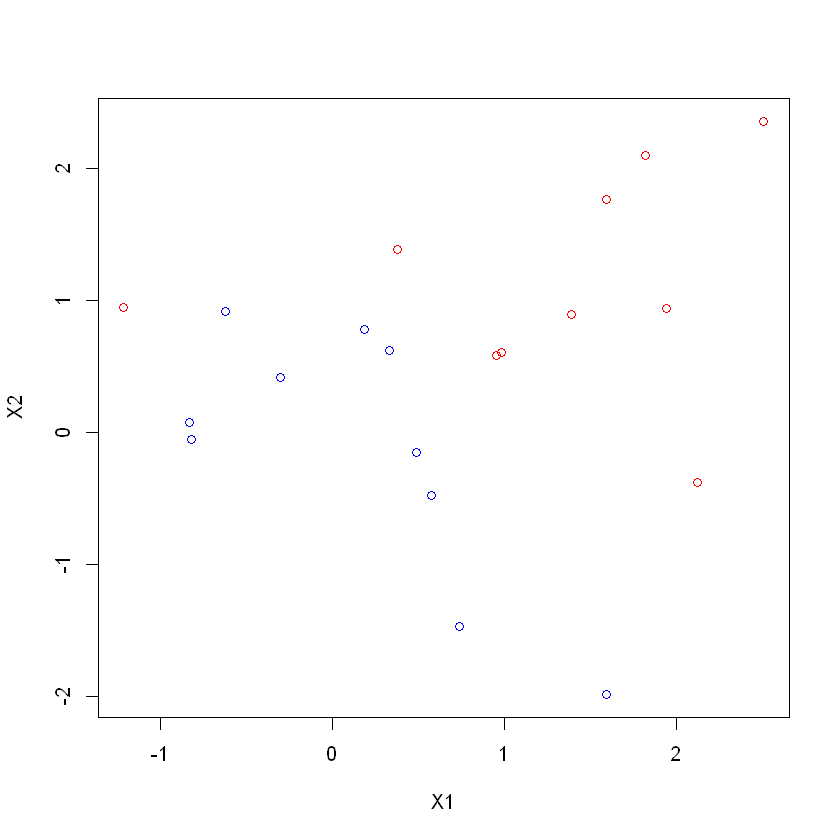

In [14]:
set.seed(1)
X <- matrix(rnorm(20 * 2), ncol = 2) # random sample matrix from a normal distribution with mean = 0 and standard deviation = 1
y <- c(rep(-1, 10), rep(1, 10)) # two classes y = -1 and y = 1
X[y == 1, ] <- X[y == 1, ] + 1 # adds 1 to data points with y = 1 to somewhat pull them apart from those with y = -1 (still, the two classes are not linearly separable)
plot(X, col = (3 - y), xlab = "X1", ylab = "X2") # plots the data points with different colors, y = 1 -> red (2), y = - 1 -> blue (4)

We can see from the plot that we would not be able to fit a linear decision bounday without setting the margin to include some observations between it and the decision boundary.


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




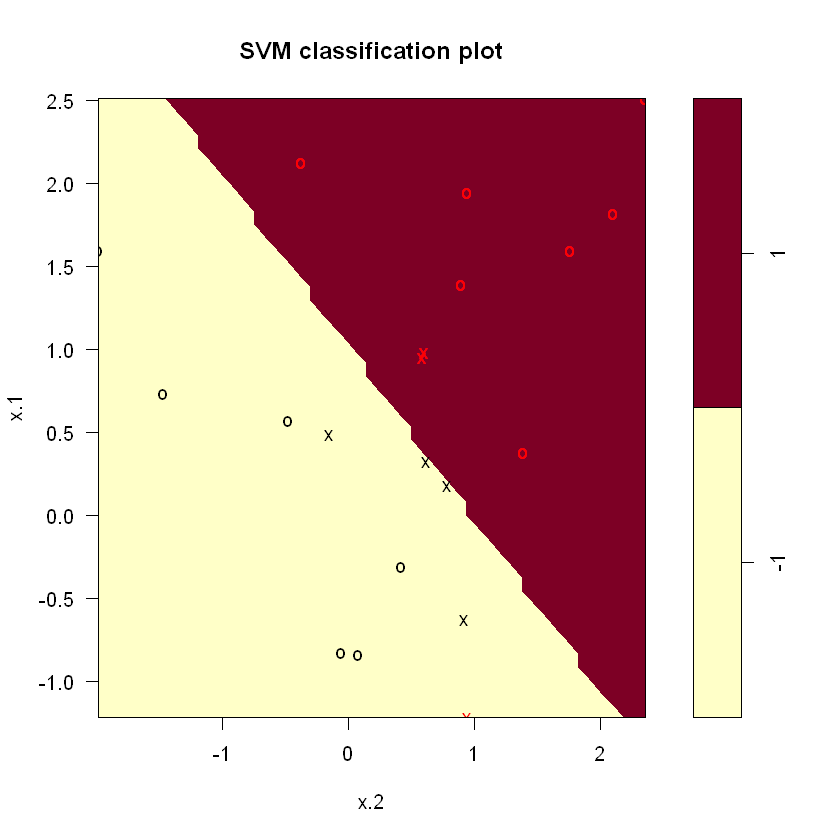

In [15]:
dat <- data.frame(x = X, y = as.factor(y)) # the response variable is encoded as a variable of (two) classes
library(e1071)
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE) 
summary(svmfit)
plot(svmfit, dat)

We try now different values of the cost, the higher is the value of the cost the larger is the margin and the more data point are allowed to be between the margin and the decision boundary.

In [16]:
set.seed(1)
cost_range <- c(0.001, 0.01, 0.1, 1.5, 10, 100)
tune.out <- tune(svm, y ~ ., data = dat, kernel = "linear", ranges = list(cost = cost_range))
best_model <- tune.out$best.model
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.05 

- Detailed performance results:
     cost error dispersion
1   0.001  0.55  0.4377975
2   0.010  0.55  0.4377975
3   0.100  0.05  0.1581139
4   1.500  0.15  0.2415229
5  10.000  0.15  0.2415229
6 100.000  0.15  0.2415229


We can see that the lowest cross-validation error is when cost = 0.1. We will use the best model, with cost = 0.1, to make predictions. Before that we need to create a test set of observations, then we use the best model to predict the class of each observation and finally we see how many observations have been misclassified.

In [17]:
set.seed(1)
Xtest <- matrix(rnorm(20 * 2), ncol = 2) # random sample matrix from a normal distribution with mean = 0 and standard deviation = 1
ytest <- sample(c(-1, 1), size = 20, replace = TRUE) # random permutations with replacement from the set {-1, 1}
Xtest[ytest == 1, ] <- Xtest[ytest == 1, ] + 1 # adds 1 to the data points for which ytest = 1
testdat <- data.frame(x = Xtest, y = as.factor(ytest))
ypred <- predict(best_model, testdat)
conf_matrix <- table(predict = ypred, truth = testdat$y) # confusion matrix
conf_matrix
TP <- conf_matrix[2, 2] # true positives, observations that belong to the class {+1}
TN <- conf_matrix[1, 1] # true negatives, observations that belong to the class {-1}
(1 - (TP + TN) / 20) * 100 # percentage of misclassified data points

       truth
predict -1 1
     -1  9 3
     1   2 6

[1] 25

### 9.6.2 Support Vector Machine
We want to move beyond the linear model in order to be able to separate observations that belong to classes that are far from being linearly separable. We can use the same svm() function that we used for the linear case, we just need to set the kernel to "polynomial" or "radial". We first create a data set of observations that will belong to two classes that are not linearly separable. 

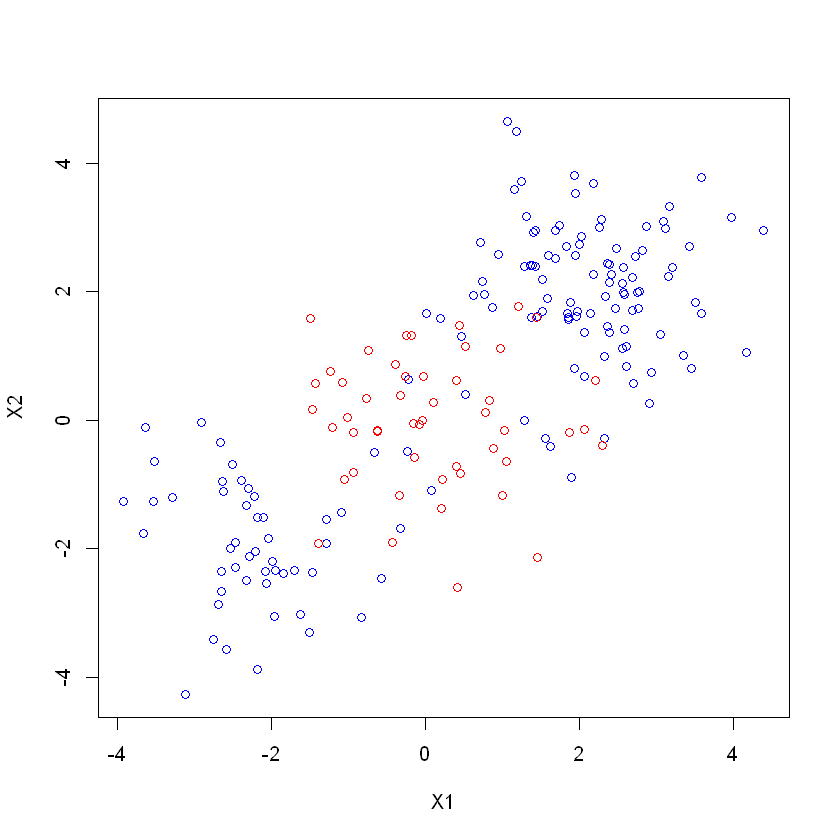

In [18]:
set.seed(1)
X <- matrix(rnorm(200 * 2), ncol = 2) # random sample matrix from a normal distribution with mean = 0 and standard deviation = 1
X[1:100, ] <- X[1:100, ] + 2
X[101:150, ] <- X[101:150, ] - 2
y <- c(rep(-1, 150), rep(1, 50))
dat <- data.frame(x = X, y = as.factor(y))
plot(X, col = (3 - y), xlab = "X1", ylab = "X2") # plots the data points with different colors, y = 1 -> red (2), y = - 1 -> blue (4)

The two classes, 1 and 2 represented as black and red dots respectively, are not linearly separable. We split the observations randomly into a training set and a test set and use the training set to fit a model with the radial kernel.


Call:
svm(formula = y ~ ., data = dat[train, ], kernel = "radial", gamma = 1, 
    cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  31

 ( 16 15 )


Number of Classes:  2 

Levels: 
 -1 1




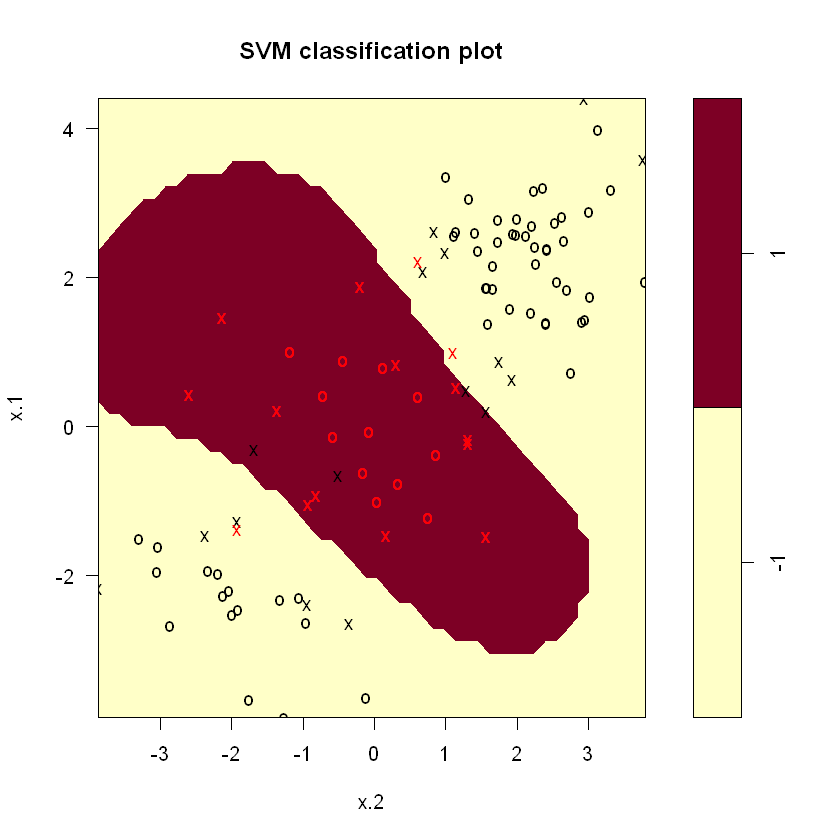

In [19]:
train <- sample(200, 100) # create a sample of 100 integers from a set that ranges from 1 to 200 (each with probability 1/200)
svmfit <- svm(y ~ ., data = dat[train, ], kernel = "radial", gamma = 1, cost = 1)
summary(svmfit)
plot(svmfit, dat[train, ])

We now train different non-linear support vector machines using the radial kernel with different values of the gamma parameter and of the cost parameter. As we saw before, the higher is the value of the cost, the larger is the margin and the more data points are allowed to be between the margin and the decision boundary. The gamma parameter weights the distance of a data point from a training observation. A large value of the gama parameter decreases the relevance of observations that are far from the training data points, in other words, the kernel is more localized. In particular we try 5 values for the cost and 5 values for the gamma parameter for a total of 25 models. We use cross-validation to select the best model on the training data set.

In [20]:
set.seed(1)
cost_range <- c(0.1, 1, 10, 100, 1000)
gamma_range <- c(0.5, 1, 2, 3, 4)
tune.out <- tune(svm, y ~ ., data = dat[train, ], kernel = "radial", ranges = list(cost = cost_range, gamma = gamma_range))
best_model <- tune.out$best.model
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.07 

- Detailed performance results:
    cost gamma error dispersion
1  1e-01   0.5  0.26 0.15776213
2  1e+00   0.5  0.07 0.08232726
3  1e+01   0.5  0.07 0.08232726
4  1e+02   0.5  0.14 0.15055453
5  1e+03   0.5  0.11 0.07378648
6  1e-01   1.0  0.22 0.16193277
7  1e+00   1.0  0.07 0.08232726
8  1e+01   1.0  0.09 0.07378648
9  1e+02   1.0  0.12 0.12292726
10 1e+03   1.0  0.11 0.11005049
11 1e-01   2.0  0.27 0.15670212
12 1e+00   2.0  0.07 0.08232726
13 1e+01   2.0  0.11 0.07378648
14 1e+02   2.0  0.12 0.13165612
15 1e+03   2.0  0.16 0.13498971
16 1e-01   3.0  0.27 0.15670212
17 1e+00   3.0  0.07 0.08232726
18 1e+01   3.0  0.08 0.07888106
19 1e+02   3.0  0.13 0.14181365
20 1e+03   3.0  0.15 0.13540064
21 1e-01   4.0  0.27 0.15670212
22 1e+00   4.0  0.07 0.08232726
23 1e+01   4.0  0.09 0.07378648
24 1e+02   4.0  0.13 0.14181365
25 1e+03   4.0  0.15 0

We now use the best model to predict the class of observations in the test data set. We will also print the confusion matrix that contains the true positives and negatives and the false positives and negatives that we will discuss in the next section about the ROC curves.

In [21]:
Xtest <- X[-train, ]
ytest <- y[-train]
testdat <- data.frame(x = Xtest, y = as.factor(ytest))
ypred <- predict(best_model, testdat)
conf_matrix <- table(predict = ypred, truth = testdat$y) # confusion matrix 
conf_matrix
TN <- conf_matrix[1,1] # true negatives
TP <- conf_matrix[2,2] # true positives
(1 - (TN + TP) / 100) * 100 # percentage of misclassified data points

       truth
predict -1  1
     -1 67  2
     1  10 21

[1] 12

### 9.6.3 ROC Curves
Let's suppose that we want to predict what are the chances that an individual that is applying for a mortgage will default. We have a data set of individuals, separated in two classes, default and no-default. In a binary classification two types of errors can be made: assigning an individual who will defaults to the non-default class (positives), maybe the worst error, or an individual who will not default to the default class (negatives). The first case is called false positive (FP), and the second case is called false negative (FN). As we have seen, the predict() function uses the decision boundary, that has been fitted from the training set, to predict the class of the observations in the test set and to compare the results with the data. These results are available as a confusion matrix, with the true positives (TP) and the true negatives (TN) in the diagonal and the false positives and the false negatives off the diagonal. These values depend on the data set used for the training. We can compute different confusion matrices using the values of the function 

$$f(x) = \beta_0 + \sum_{i \in S} \alpha_i \langle x, x_i \rangle $$

as cutoff values. The prediction() function uses the values of the decision boundary computed on the training observations as cutoffs. So we can compute a confusion matrix using the predictions for each cutoff and see which one has the best performances on specific metrics. As we noted, from the point of view of the bank that must decide about granting a mortgage or not, it is much worse granting a mortage to an individual who will default (FN), than missing a profit not granting a mortgage to someone who will not default (FP). The bank would likely care more about false negatives (FP) than true positives (TP) or true positives and true negatives (TN) combined. We will see an example, using the Default data set from the ISLR package, in which we want to predict the probability of default of individuals. For simplicity we will use only two predictors, income and balance. We will compute the confusion matrices with which we will be able to draw a ROC curve, of the true positive rate (TPR), also called sensitivity or recall, and the false positive rate (FPR)

$$TPR = \frac{TP}{TP + FN}$$, $$FPR = \frac{FP}{FP + TN}$$

The TPR gives us the fraction of non-defaulters that are correctly classified using a certain cutoff value. The FPR gives us the fraction of defaulters that we classify incorrectly using the same cutoff. In the case of the bank we want to choose a cutoff that results in a low FPR even at the expense of the TPR. 

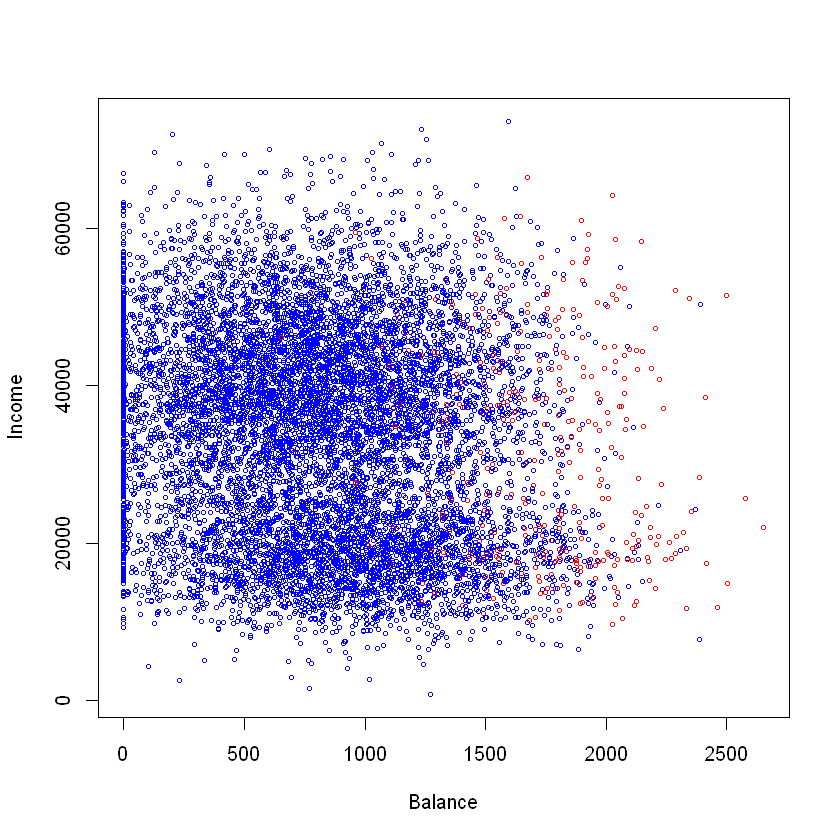

In [93]:
library(ISLR)
X<-Default[,c(3,4)] # X1 -> balance, X2 -> income
y<-Default$default
y <- as.numeric(y) - 1 # changes the type from {'No', 'Yes'} to {0, 1}
y <- 1 - y # changes positives (no-default) from 0 to 1, and negatives (default) from 1 to 0 (it must be positive > negative)
plot(X, col = (2 + 2*y), cex = 0.5, xlab = "Balance", ylab = "Income") # blue -> no default, red -> default 

We split the data set as usual in a training set and a test set

In [86]:
train <- sample(10000, 5000) # random integers for index of train data
dat <- data.frame(x = X, y = as.factor(y))

We import the libraries for the support vector machines algorithms and for the ROC curves. 

In [87]:
library(e1071)
library(ROCR)

We can fit the training data using svm with different kernels

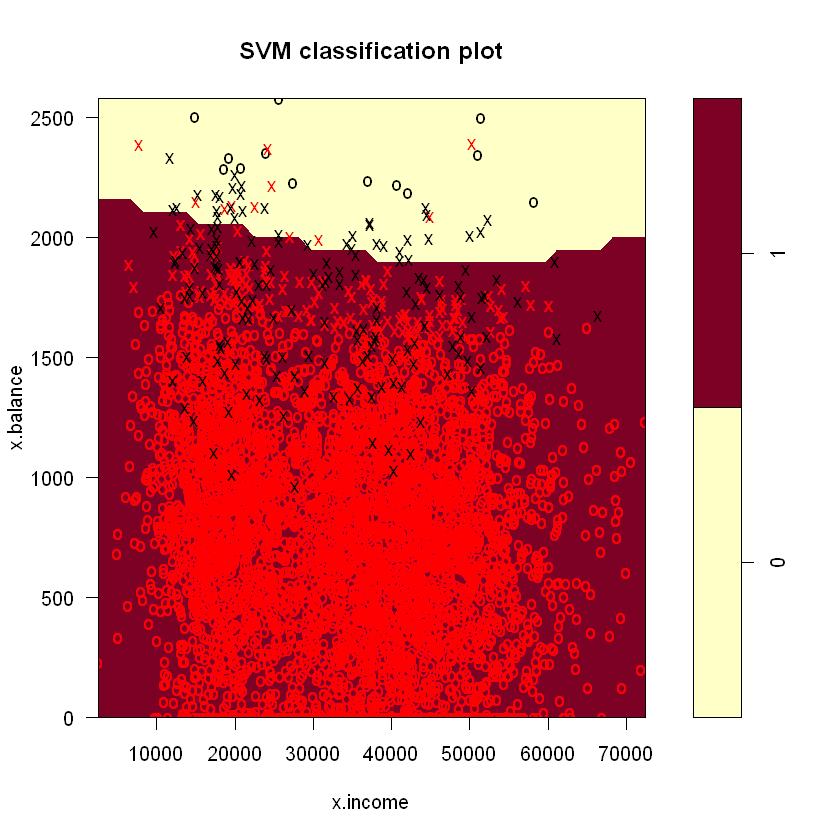

In [88]:
#svmfit <- svm(y ~ ., data = dat[train, ], kernel = "radial", gamma = 3, cost = 10)
svmfit <- svm(y ~ ., data = dat[train, ], kernel = "polynomial", degree = 3, cost = 5, scale = TRUE)
plot(svmfit, dat[train, ])

We define a function that we will use to plot the ROC curves and to compute the area under the curve (AUC) measure.

In [94]:
rocplot <- function(pred, truth, ...) {
  predob <- prediction(pred, truth) # if positive < negative set label.ordering accordingly 
  perf <- performance(predob, measure = "tpr", x.measure = "fpr") 
  plot(perf, col = "blue", colorize = TRUE, ...)
  auc <- performance(predob, measure = "auc")
  abline(a=0, b= 1)
  return(auc)
}

We compute the confusion matrices for all the cutoffs and plot the results for the training set and the test set.

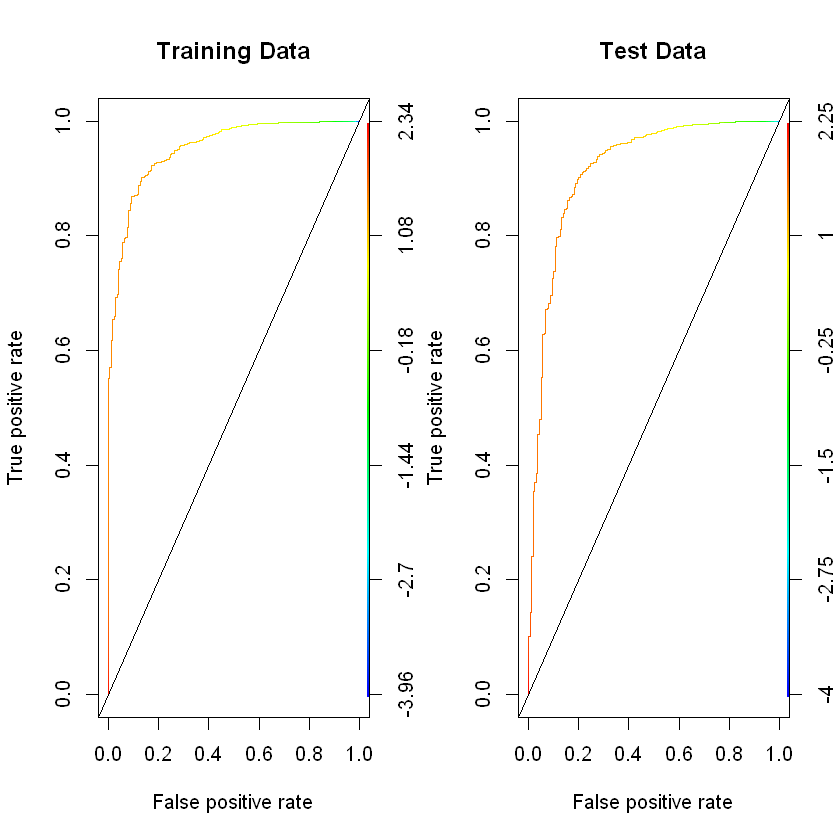

In [90]:
par(mfrow = c(1,2))
fitted_train <- attributes(predict(svmfit, dat[train, ], decision.values = TRUE))$decision.values
auc_train <- rocplot(fitted_train, dat[train, "y"], main = "Training Data")@y.values[[1]]
fitted_test <- attributes(predict(svmfit, dat[-train, ], decision.values = TRUE))$decision.values
auc_test <-rocplot(fitted_test, dat[-train,"y"], main = "Test Data")@y.values[[1]]

We print also the areas under the two ROC curves

In [91]:
auc_train; auc_test

[1] 0.9513709

[1] 0.9152028